Perform an area-wide correlation analysis of vehicle emissions.
Determine spatial variation, and variation based on other factors, such as land use of surrounding areas, population, network classification (road type), weather, etc.
Correlate the provided emissions data with other provided datasets.

### Global imports

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import glob

In [2]:
ls

README.md                   scripts/
data/                       snapshot_to_building.ipynb
q2.ipynb


In [173]:
links=gpd.read_file("data/road_network/RoadNetwork.geojson")
links = links.rename(columns={'LINKID': 'linkID'})

,linkID,FROM,TO,FCC,SPEED,MILES,LANES,DIRECT,geometry
0,0,0,1,A50,None,None,None,0,"LINESTRING (-87.62436 41.87701, -87.62451 41.8..."
1,1,1,2,A50,None,None,None,0,"LINESTRING (-87.62451 41.87700, -87.62523 41.8..."
2,2,2,3,A50,None,None,None,0,"LINESTRING (-87.62523 41.87698, -87.62605 41.8..."
3,3,3,4,A50,None,None,None,0,"LINESTRING (-87.62605 41.87695, -87.62634 41.8..."
4,4,4,5,A50,None,None,None,0,"LINESTRING (-87.62634 41.87696, -87.62654 41.8..."
...,...,...,...,...,...,...,...,...,...
2610,2610,192,-266,A00,None,None,None,0,"LINESTRING (-87.64545 41.87783, -87.64558 41.8..."
2611,2611,669,-267,A00,None,None,None,0,"LINESTRING (-87.64545 41.87924, -87.64559 41.8..."
2612,2612,544,-268,A00,None,None,None,0,"LINESTRING (-87.64546 41.87544, -87.64560 41.8..."
2613,2613,1262,-269,A00,None,None,None,0,"LINESTRING (-87.64550 41.87572, -87.64563 41.8..."


In [4]:
emissions=pd.read_csv('data/emissions_data/Emissions/2017-01-09_07_energy.csv')
emissions

,hour,linkID,pollutantID,emrate,emquant
0,7,2,91,8.210320e+05,30751.423168
1,7,3,91,8.210320e+05,34707.868976
2,7,4,91,8.210320e+05,12255.879647
3,7,5,91,8.210320e+05,8506.983011
4,7,7,91,8.210320e+05,7038.390622
...,...,...,...,...,...
1156,7,2583,91,0.000000e+00,0.000000
1157,7,2585,91,8.927560e+05,4160.496323
1158,7,2586,91,0.000000e+00,0.000000
1159,7,2591,91,2.400668e+06,11187.795453


In [5]:
links['linkID']=links['linkID'].astype(float)
emissions['linkID']=emissions['linkID'].astype(float)

### Merge road network and emission dataset

In [6]:
emission_links=links.merge(emissions, on='linkID')

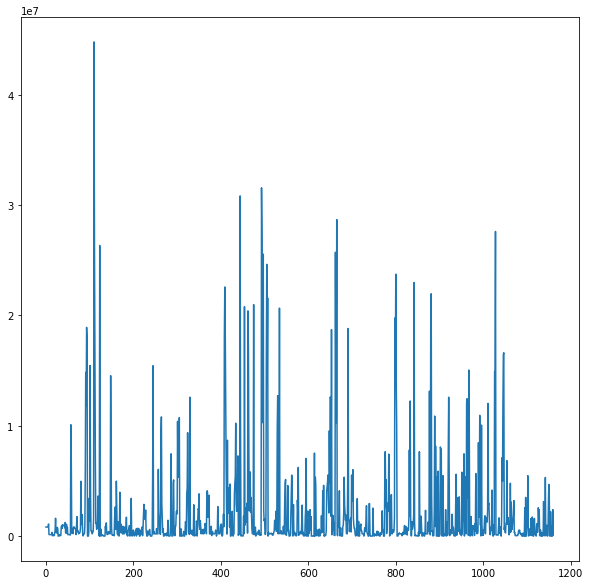

In [7]:
fig,ax = plt.subplots(figsize = (10,10))
emission_links['emrate'].plot(ax=ax)
plt.show()

### Example plot from one emissions set.

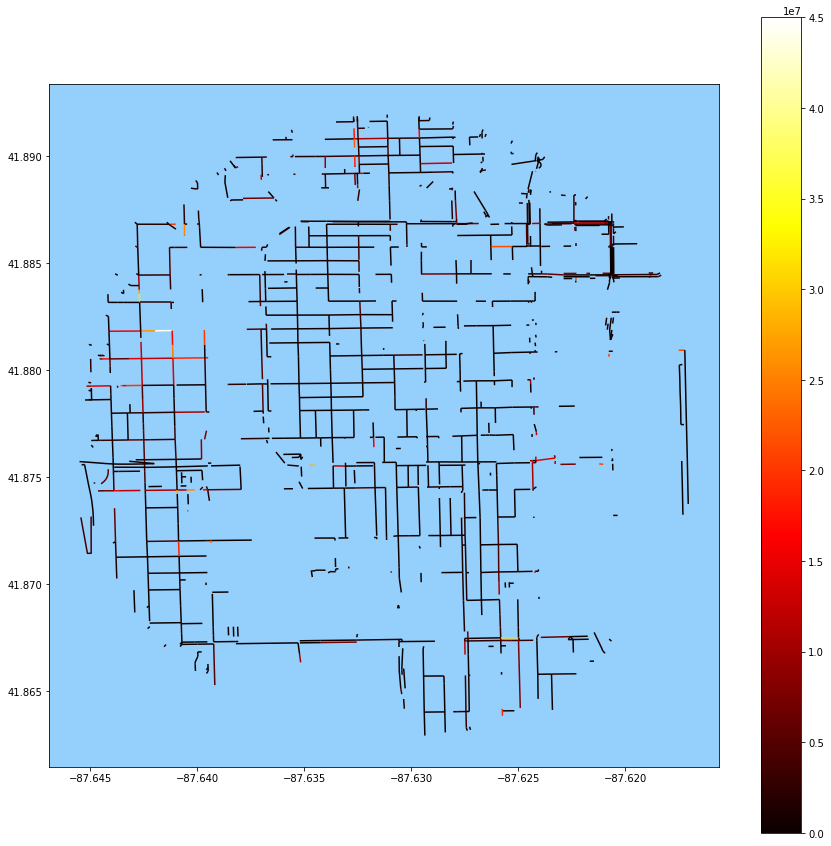

In [12]:
fig,ax = plt.subplots(figsize = (15,15))
emission_links.plot(ax=ax, column='emrate',cmap='hot',vmin=0, vmax=45000000)
ax.set_facecolor('xkcd:light blue')
fig = ax.get_figure()
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=45000000))
fig.colorbar(sm, ax=ax)

# Scaling

Import and concatenate all emissions data by day, group by link ID and plot over time (daily and beyond). (DONE)

Get weather data for each emissions snapshot - will it vary within the Chicago Loop? I dont think so.

Census data - connect tracts with links

Road type - which dataset is this - no metadata on links??

### Concatenate days of emissions data

Sorted filenames and added datetimes.

In [122]:
path = r'data/emissions_data/Emissions/' # use your path
jan2017 = glob.glob(path + "/2017-01-09*.csv")
li = []
jan2017.sort()
for filename in jan2017:
    df = pd.read_csv(filename, index_col=None, header=0)
    hour=str(df.loc[0,'hour'])
    df['date'] = filename[30:40]+'-'+hour+':00'
    df['date']=pd.to_datetime(df['date'])
    li.append(df)

jan_2017 = pd.concat(li, axis=0, ignore_index=True)

In [116]:
path = r'data/emissions_data/Emissions/' # use your path
july2017 = glob.glob(path + "/2017-07*.csv")
li = []
july2017.sort()
for filename in july2017:
    df = pd.read_csv(filename, index_col=None, header=0)
    hour=str(df.loc[0,'hour'])
    df['date'] = filename[30:40]+'-'+hour+':00'
    df['date']=pd.to_datetime(df['date'])
    li.append(df)

july_2017 = pd.concat(li, axis=0, ignore_index=True)

Need to add datetime columns to `jan_2017` and `july_2017`

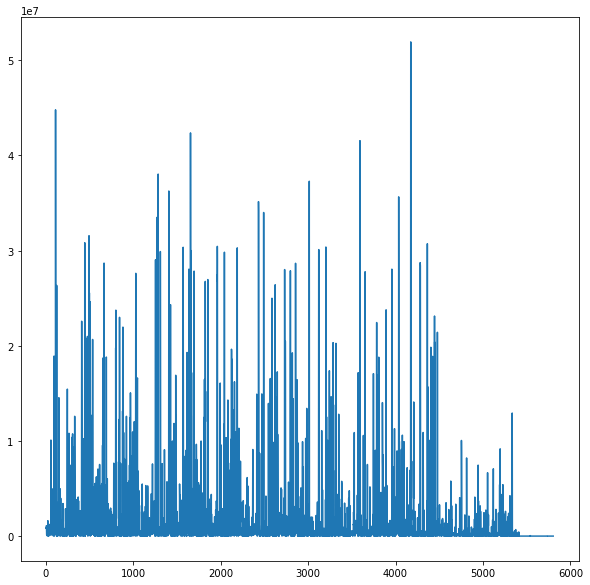

In [145]:
fig,ax = plt.subplots(figsize = (10,10))
jan_2017['emrate'].plot()

In [148]:
july_2017.sort_values(by='emrate',ascending=False)

,hour,linkID,pollutantID,emrate,emquant,date
12301,10,1379,91,5.554064e+07,1.906565e+06,2017-07-04 10:00:00
68029,10,1379,91,5.554064e+07,1.906565e+06,2017-07-06 10:00:00
151621,10,1379,91,5.554064e+07,1.906565e+06,2017-07-09 10:00:00
40165,10,1379,91,5.554064e+07,1.906565e+06,2017-07-05 10:00:00
95893,10,1379,91,5.554064e+07,1.906565e+06,2017-07-07 10:00:00
...,...,...,...,...,...,...
73185,15,66,91,0.000000e+00,0.000000e+00,2017-07-06 15:00:00
73186,15,67,91,0.000000e+00,0.000000e+00,2017-07-06 15:00:00
73187,15,69,91,0.000000e+00,0.000000e+00,2017-07-06 15:00:00
73188,15,70,91,0.000000e+00,0.000000e+00,2017-07-06 15:00:00


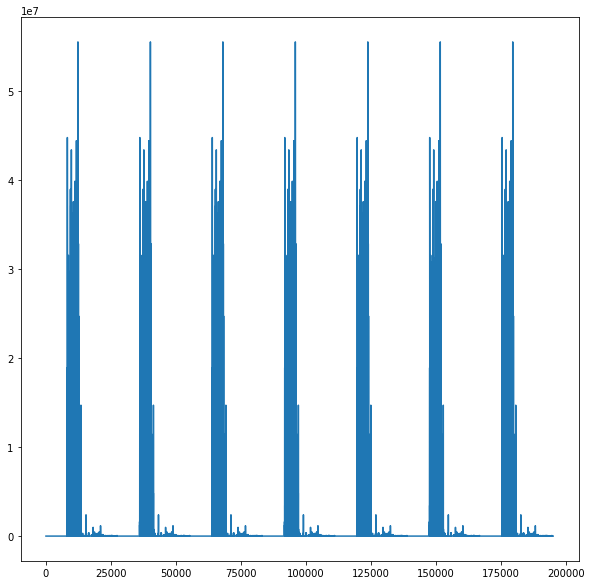

In [144]:
fig,ax = plt.subplots(figsize = (10,10))
july_2017['emrate'].plot()

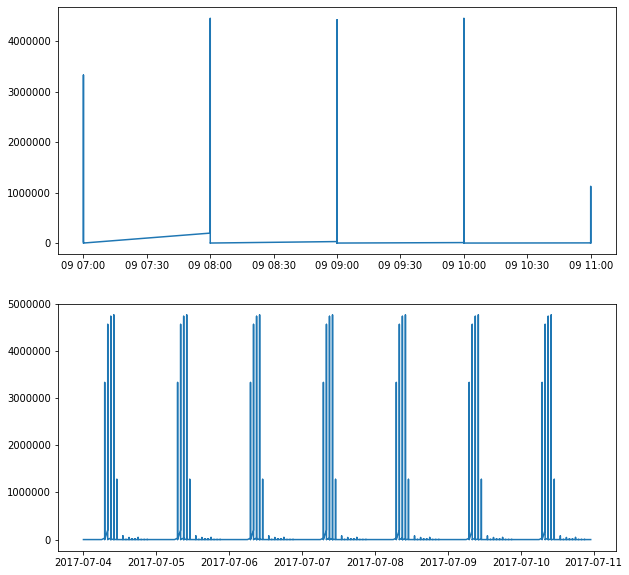

In [153]:
f, (ax1, ax2) = plt.subplots(2,figsize = (10,10))
ax1.plot(jan_2017['date'], jan_2017['emquant'])
ax2.plot(july_2017['date'], july_2017['emquant'])
#sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=45000000))
#fig.colorbar(sm, ax=ax1)
plt.show()

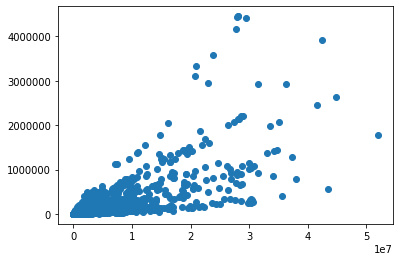

In [143]:
fig,ax=plt.subplots()
ax.scatter(jan_2017['emrate'],jan_2017['emquant'])
plt.show()

### Population

merge Community Area Boundaries shapefile + 2013 -2017 document.

#### Question - do we want to go onto census tract level?

In [159]:
population=pd.read_csv('data/socioeconomic_data/Population/2013-2017.csv')
community_bound=gpd.read_file("data/socioeconomic_data/Community Area Snapshots/Boundaries_Community_Areas_current.geojson")



In [162]:
community_bound
#population

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...,...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,0,75584290.0209,0,74,74,0,0,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MORGAN PARK,0,91877340.6988,0,75,75,0,0,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,OHARE,0,371835607.687,0,76,76,0,0,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,EDGEWATER,0,48449990.8397,0,77,77,0,0,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


Rename columns

In [168]:
#population = population.rename(columns={'GEOG': 'community'})
population['community']=population['community'].apply(lambda x: x.upper())

Merge

In [172]:
pop_georef=population.merge(community_bound, on='community')
pop_georef

,community,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,...,nonsov_pct,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,ALBANY PARK,57655,51542,51992,13299,14031,11658,8134,2603,1573,...,0.499174,0,53542230.8191,0,14,14,0,0,39339.0164387,"MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ..."
1,ARCHER HEIGHTS,12644,13393,13142,4017,2827,2925,1818,970,323,...,0.363994,0,55922505.7212,0,57,57,0,0,31880.0210295,"MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ..."
2,ARMOUR SQUARE,12032,13391,13455,2634,2816,2376,2522,1540,1097,...,0.620298,0,27766196.0954,0,34,34,0,0,31948.5988398,"MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ..."
3,ASHBURN,39584,41081,43792,12999,8377,9200,8567,3031,999,...,0.294516,0,135460337.208,0,70,70,0,0,54818.1546317,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ..."
4,AUBURN GRESHAM,55928,48743,46278,11696,9176,7871,9857,3810,2966,...,0.401112,0,105065353.602,0,71,71,0,0,46757.7217161,"MULTIPOLYGON (((-87.63990 41.75615, -87.63990 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,WEST LAWN,29235,33355,33108,11067,7535,6990,4642,1748,805,...,0.343872,0,82315301.6831,0,65,65,0,0,41934.4901309,"MULTIPOLYGON (((-87.71255 41.75734, -87.71278 ..."
71,WEST PULLMAN,36649,29651,27742,7812,5719,4594,5351,2719,1178,...,0.340913,0,99365198.0822,0,53,53,0,0,50023.8430008,"MULTIPOLYGON (((-87.61828 41.65911, -87.61829 ..."
72,WEST RIDGE,73199,71942,76215,20756,17065,15001,13648,5461,2914,...,0.397698,0,98429094.8621,0,2,2,0,0,43020.6894583,"MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ..."
73,WEST TOWN,87435,82236,84502,13570,37651,19528,8662,3234,1429,...,0.587723,0,127562904.597,0,24,24,0,0,55203.7186956,"MULTIPOLYGON (((-87.65686 41.91078, -87.65685 ..."


In [202]:
pop_gpd=gpd.GeoDataFrame(pop_georef, geometry='geometry')
pop_gpd.to_file("pop_georef.geojson", driver='GeoJSON')
pop_gpd.crs={'init': 'epsg:26916'}

In [199]:
end_sim.crs

{'init': 'epsg:26916'}

In [209]:
pop_vehicles = gpd.sjoin(pop_gpd, end_sim, how="left", op='contains')
pop_vehicles ##need to work on this merge

,community,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,...,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD
0,ALBANY PARK,57655,51542,51992,13299,14031,11658,8134,2603,1573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARCHER HEIGHTS,12644,13393,13142,4017,2827,2925,1818,970,323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARMOUR SQUARE,12032,13391,13455,2634,2816,2376,2522,1540,1097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ASHBURN,39584,41081,43792,12999,8377,9200,8567,3031,999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUBURN GRESHAM,55928,48743,46278,11696,9176,7871,9857,3810,2966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,WEST LAWN,29235,33355,33108,11067,7535,6990,4642,1748,805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,WEST PULLMAN,36649,29651,27742,7812,5719,4594,5351,2719,1178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,WEST RIDGE,73199,71942,76215,20756,17065,15001,13648,5461,2914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,WEST TOWN,87435,82236,84502,13570,37651,19528,8662,3234,1429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
sim_snap_geojson = gpd.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
def start(sim_snap_df:str,sim_start:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_start_gpd = sim_snap_df.head(1)
    return sim_start_gpd

def end(sim_snap_df:str,sim_end:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

In [182]:
end_sim=end(sim_snap_geojson,'03:00')